<a href="https://colab.research.google.com/github/amrahmani/Marketing/blob/main/AIMarketing_Ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of new customers (enrolled since 2013-12-14): 220

--- K-Means Clustering on New Customers ---


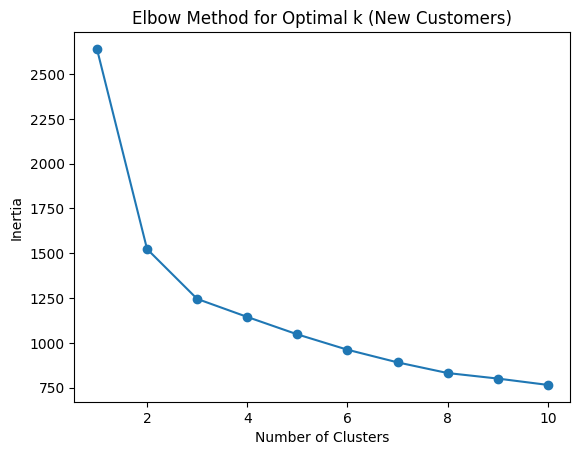


New customers assigned to 3 clusters.
cluster
0    116
1     60
2     44
Name: count, dtype: int64

--- Logistic Regression for Response Prediction (New Customers) ---

--- Analyzing Clustering Results ---

Cluster Profiles (Mean Values):
               Income    Recency    MntWines  MntFruits  MntMeatProducts  \
cluster                                                                    
0        39967.920354  50.284483   38.896552   3.137931        16.422414   
1        66532.650000  48.950000  434.133333  21.133333       161.850000   
2        82068.386364  48.795455  528.409091  92.181818       531.613636   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumWebPurchases  \
cluster                                                                     
0               4.344828          3.284483     10.103448         1.836207   
1              38.850000         21.666667     38.633333         5.833333   
2             112.204545         81.886364     85.840909         4.4318

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96        41
           1       0.00      0.00      0.00         3

    accuracy                           0.93        44
   macro avg       0.47      0.50      0.48        44
weighted avg       0.87      0.93      0.90        44


AUC-ROC Score: 0.7398373983739837


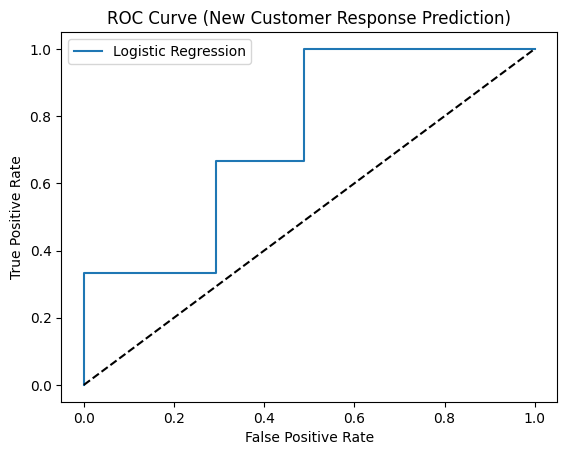


Feature Importance (Logistic Regression Coefficients):
             Feature  Coefficient  Abs_Coefficient
5          cluster_0    -1.336487         1.336487
1            Recency    -0.817282         0.817282
6          cluster_1    -0.591275         0.591275
3    NumWebPurchases    -0.570943         0.570943
2           MntWines     0.511415         0.511415
7          cluster_2    -0.256457         0.256457
0             Income     0.120280         0.120280
4  NumWebVisitsMonth     0.090667         0.090667


In [1]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv')

# Convert 'Dt_Customer' to datetime objects
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# --- Step 1: Define "New Customers" Dynamically ---
# Find the most recent enrollment date
most_recent_enrollment = df['Dt_Customer'].max()

# Calculate the cutoff date for the last 6 months
cutoff_date = most_recent_enrollment - timedelta(days=6 * 30) # Approximately 6 months

# Filter for new customers
new_customers_df = df[df['Dt_Customer'] >= cutoff_date].copy()
print(f"Number of new customers (enrolled since {cutoff_date.strftime('%Y-%m-%d')}): {len(new_customers_df)}")

# --- Step 2: Clustering on New Customers (using K-Means) ---
print("\n--- K-Means Clustering on New Customers ---")

# Select features for clustering
features_for_clustering = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                           'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                           'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                           'NumWebVisitsMonth']
clustering_data = new_customers_df[features_for_clustering].copy()

# Handle missing values
imputer_cluster = SimpleImputer(strategy='mean')
clustering_data_imputed = pd.DataFrame(imputer_cluster.fit_transform(clustering_data),
                                        columns=clustering_data.columns)

# Scale the data
scaler_cluster = StandardScaler()
scaled_clustering_data = scaler_cluster.fit_transform(clustering_data_imputed)
scaled_clustering_df = pd.DataFrame(scaled_clustering_data, columns=clustering_data.columns)

# Determine the optimal number of clusters (Elbow method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_clustering_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k (New Customers)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means with a chosen k (let's assume k=3 based on the plot)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
new_customers_df['cluster'] = kmeans.fit_predict(scaled_clustering_data)

print(f"\nNew customers assigned to {n_clusters} clusters.")
print(new_customers_df['cluster'].value_counts())

# --- Step 3: Classification Models on New Customers (using Logistic Regression) ---
print("\n--- Logistic Regression for Response Prediction (New Customers) ---")

# Prepare data for classification
X = new_customers_df[['Income', 'Recency', 'MntWines', 'NumWebPurchases', 'NumWebVisitsMonth', 'cluster']]
y = new_customers_df['Response']

# Identify numerical and categorical features
numerical_features_lr = ['Income', 'Recency', 'MntWines', 'NumWebPurchases', 'NumWebVisitsMonth']
categorical_features_lr = ['cluster']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_lr),
        ('cat', categorical_transformer, categorical_features_lr)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_model = Pipeline(steps=[('preprocessor', preprocessor_lr),
                                 ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# --- Step 4: Analyze the Results ---
print("\n--- Analyzing Clustering Results ---")
# Analyze cluster profiles (mean values for numerical features, mode for categorical)
cluster_profiles = new_customers_df.groupby('cluster')[features_for_clustering + ['Response']].mean()
print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)

# Analyze response rate per cluster
response_rate_per_cluster = new_customers_df.groupby('cluster')['Response'].mean()
print("\nResponse Rate per Cluster:")
print(response_rate_per_cluster)

print("\n--- Analyzing Logistic Regression Results ---")
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (New Customer Response Prediction)')
plt.legend()
plt.show()

# Feature Importance (interpreting coefficients after preprocessing)
feature_names = numerical_features_lr + [f'cluster_{i}' for i in range(n_clusters)]
coefficients = logistic_model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance)

complete version

Number of new customers (enrolled since 2013-12-14): 220

--- K-Means Clustering on New Customers ---


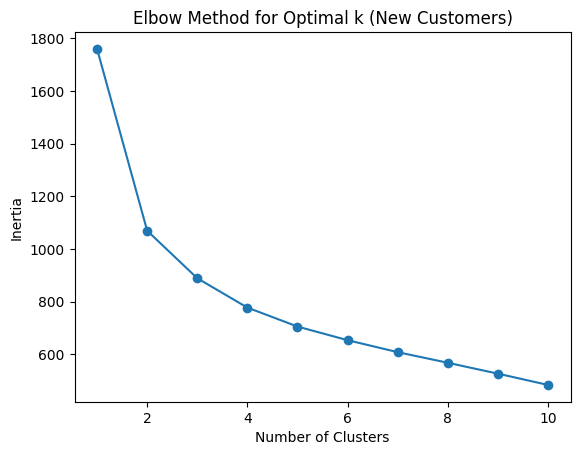


New customers assigned to 3 clusters.
cluster
0    105
2     62
1     53
Name: count, dtype: int64

--- Cluster Analysis ---

Cluster Profiles (Mean Values):
               Income    Recency  Total_Spending  NumWebPurchases  \
cluster                                                             
0        37780.931373  51.342857       77.866667         1.933333   
1        62532.735849  47.169811      554.358491         5.226415   
2        79862.145161  48.806452     1246.306452         4.483871   

         NumStorePurchases  NumWebVisitsMonth   Kidhome  Teenhome  Response  
cluster                                                                      
0                 3.114286           5.838095  0.961905  0.485714  0.038095  
1                 6.509434           4.396226  0.037736  1.056604  0.018868  
2                 7.951613           1.967742  0.112903  0.032258  0.129032  

Average Response Rate per Cluster:
cluster
0    0.038095
1    0.018868
2    0.129032
Name: Response, dty

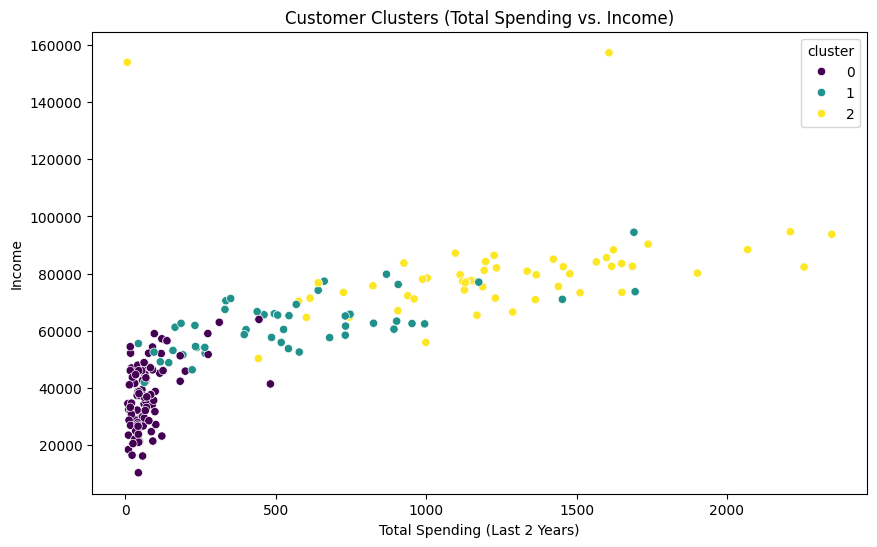


--- Target Segment Selection (Cluster 1) ---
Number of customers in Cluster 1: 53

Characteristics of Target Segment (Mean Values):
Income               62532.735849
Recency                 47.169811
Total_Spending         554.358491
NumWebPurchases          5.226415
NumStorePurchases        6.509434
NumWebVisitsMonth        4.396226
Kidhome                  0.037736
Teenhome                 1.056604
Response                 0.018868
dtype: float64

--- Direct Marketing Campaign Design for the Target Segment ---
Campaign Name: Welcome & Discover Our Premium Selection
Campaign Goal: Acquire new customers from the identified high-potential segment and drive initial purchases.
Target Audience Description: New customers identified in Cluster 1. Based on our analysis, this segment tends to have an average income of $62532.74, a recency of 47.17 days, and a total spending of $554.36. They also show an average of 5.23 web purchases and 6.51 store purchases. Their average response rate to the

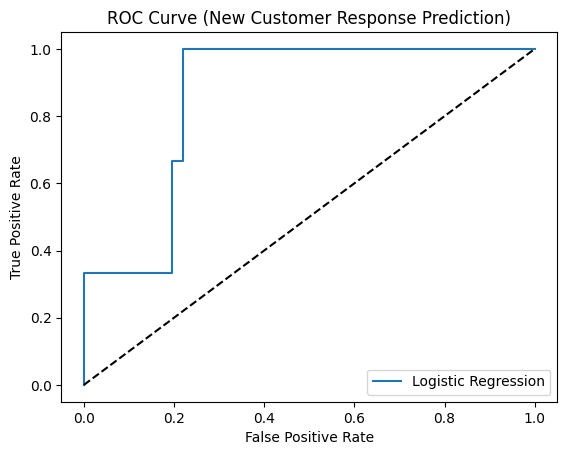


Feature Importance (Logistic Regression Coefficients):
             Feature  Coefficient  Abs_Coefficient
2     Total_Spending     1.095467         1.095467
7          cluster_0    -1.043715         1.043715
1            Recency    -0.838585         0.838585
8          cluster_1    -0.709131         0.709131
9          cluster_2    -0.593186         0.593186
3    NumWebPurchases    -0.540253         0.540253
4  NumWebVisitsMonth     0.250483         0.250483
6           Teenhome    -0.202584         0.202584
0             Income    -0.162849         0.162849
5            Kidhome     0.110601         0.110601


In [2]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv')

# Convert 'Dt_Customer' to datetime objects
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# --- Step 1: Define "New Customers" Dynamically ---
# Find the most recent enrollment date
most_recent_enrollment = df['Dt_Customer'].max()

# Calculate the cutoff date for the last 6 months
cutoff_date = most_recent_enrollment - timedelta(days=6 * 30) # Approximately 6 months

# Filter for new customers
new_customers_df = df[df['Dt_Customer'] >= cutoff_date].copy()
print(f"Number of new customers (enrolled since {cutoff_date.strftime('%Y-%m-%d')}): {len(new_customers_df)}")

# --- Step 2: Clustering on New Customers (using K-Means) ---
print("\n--- K-Means Clustering on New Customers ---")

# Feature Engineering for Visualization (Total Spending)
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
new_customers_df['Total_Spending'] = new_customers_df[spending_cols].sum(axis=1)

# Select features for clustering
features_for_clustering = ['Income', 'Recency', 'Total_Spending', 'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome']
clustering_data = new_customers_df[features_for_clustering].copy()

# Handle missing values
imputer_cluster = SimpleImputer(strategy='mean')
clustering_data_imputed = pd.DataFrame(imputer_cluster.fit_transform(clustering_data),
                                        columns=clustering_data.columns)

# Scale the data
scaler_cluster = StandardScaler()
scaled_clustering_data = scaler_cluster.fit_transform(clustering_data_imputed)
scaled_clustering_df = pd.DataFrame(scaled_clustering_data, columns=clustering_data.columns)

# Determine the optimal number of clusters (Elbow method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_clustering_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k (New Customers)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means with a chosen k (let's assume k=3 based on the plot)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
new_customers_df['cluster'] = kmeans.fit_predict(scaled_clustering_data)

print(f"\nNew customers assigned to {n_clusters} clusters.")
print(new_customers_df['cluster'].value_counts())

# --- Cluster Analysis ---
print("\n--- Cluster Analysis ---")
cluster_profiles = new_customers_df.groupby('cluster')[features_for_clustering + ['Response']].mean()
print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)

response_rate_per_cluster = new_customers_df.groupby('cluster')['Response'].mean()
print("\nAverage Response Rate per Cluster:")
print(response_rate_per_cluster)

# --- Cluster Visualization ---
print("\n--- Cluster Visualization ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=new_customers_df, x='Total_Spending', y='Income', hue='cluster', palette='viridis')
plt.title('Customer Clusters (Total Spending vs. Income)')
plt.xlabel('Total Spending (Last 2 Years)')
plt.ylabel('Income')
plt.show()

# --- Target Segment Selection ---
target_cluster = 1 # Example: Choosing Cluster 1 as the target segment
target_segment = new_customers_df[new_customers_df['cluster'] == target_cluster]
print(f"\n--- Target Segment Selection (Cluster {target_cluster}) ---")
print(f"Number of customers in Cluster {target_cluster}: {len(target_segment)}")
print("\nCharacteristics of Target Segment (Mean Values):")
print(target_segment[features_for_clustering + ['Response']].mean())

# --- Direct Marketing Campaign Design for the Target Segment ---
print("\n--- Direct Marketing Campaign Design for the Target Segment ---")

campaign_name = "Welcome & Discover Our Premium Selection"
campaign_goal = "Acquire new customers from the identified high-potential segment and drive initial purchases."

# Describe the target audience based on the cluster analysis
target_audience_description = (
    f"New customers identified in Cluster {target_cluster}. Based on our analysis, this segment tends to have "
    f"an average income of ${cluster_profiles.loc[target_cluster, 'Income']:.2f}, a recency of {cluster_profiles.loc[target_cluster, 'Recency']:.2f} days, "
    f"and a total spending of ${cluster_profiles.loc[target_cluster, 'Total_Spending']:.2f}. They also show an average of "
    f"{cluster_profiles.loc[target_cluster, 'NumWebPurchases']:.2f} web purchases and {cluster_profiles.loc[target_cluster, 'NumStorePurchases']:.2f} store purchases. "
    f"Their average response rate to the last campaign was {response_rate_per_cluster.loc[target_cluster]:.2f}."
)
print(f"Campaign Name: {campaign_name}")
print(f"Campaign Goal: {campaign_goal}")
print(f"Target Audience Description: {target_audience_description}")

# Tailor the marketing message
marketing_message = (
    "Welcome to our community! As a valued new customer, discover our premium selection of products tailored to your interests. "
    "Enjoy exclusive introductory offers to help you experience the quality and value we offer."
)
print(f"Marketing Message: {marketing_message}")

# Call to action
call_to_action = "Browse our curated collection and claim your special welcome gift at [Your Website Link] or visit our nearest store."
print(f"Call to Action: {call_to_action}")

# Marketing channels
marketing_channels = ["Email marketing (personalized welcome series)", "Targeted social media ads (based on demographics and interests inferred from the cluster)", "SMS/Text message with a unique offer code"]
print(f"Marketing Channels: {marketing_channels}")

# Offer
offer = "Receive a 15% discount on your first purchase using the code WELCOME15 (online and in-store)."
print(f"Offer: {offer}")

# Measurement metrics
measurement_metrics = ["Number of new customers acquired with the campaign code", "Conversion rate (offer claims / emails/ads/SMS sent)", "Average order value of first purchase", "Customer engagement with welcome emails/ads", "Cost per acquisition (CPA)"]
print(f"Measurement Metrics: {measurement_metrics}")

# AI Optimization Suggestions
ai_optimization_suggestions = [
    "A/B test different welcome offers and messaging to optimize conversion rates.",
    "Personalize product recommendations in welcome emails based on the spending patterns observed in the target cluster.",
    "Utilize optimal send time analysis for email campaigns to maximize open and click-through rates.",
    "Develop lookalike audiences based on the characteristics of the high-responding customers within this target segment for broader acquisition efforts.",
    "Implement dynamic content in emails and website banners to show products most relevant to the identified cluster's preferences."
]
print("\nAI Optimization Suggestions:")
for suggestion in ai_optimization_suggestions:
    print(f"- {suggestion}")

# --- Step 3: Classification Models on New Customers (using Logistic Regression) ---
print("\n--- Logistic Regression for Response Prediction (New Customers) ---")

# Prepare data for classification
X = new_customers_df[['Income', 'Recency', 'Total_Spending', 'NumWebPurchases', 'NumWebVisitsMonth', 'cluster', 'Kidhome', 'Teenhome']]
y = new_customers_df['Response']

# Identify numerical and categorical features
numerical_features_lr = ['Income', 'Recency', 'Total_Spending', 'NumWebPurchases', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome']
categorical_features_lr = ['cluster']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_lr),
        ('cat', categorical_transformer, categorical_features_lr)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_model = Pipeline(steps=[('preprocessor', preprocessor_lr),
                                 ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# --- Step 4: Analyze the Results ---
print("\n--- Analyzing Logistic Regression Results ---")
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (New Customer Response Prediction)')
plt.legend()
plt.show()

# Feature Importance (interpreting coefficients after preprocessing)
feature_names_encoded = (numerical_features_lr +
                         list(logistic_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['cluster'])))

coefficients = logistic_model.named_steps['classifier'].coef_[0]
feature_importance_lr = pd.DataFrame({'Feature': feature_names_encoded, 'Coefficient': coefficients})
feature_importance_lr['Abs_Coefficient'] = abs(feature_importance_lr['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance_lr)

**Continue**

**Explore and Summarize:** https://github.com/amrahmani/Marketing/blob/main/customer_segmentation_data.csv

In [ ]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/amrahmani/Marketing/main/customer_segmentation_data.csv'
df = pd.read_csv(url)

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())
print("\n")

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())
print("\n")

# Get summary statistics of the numerical columns
print("Summary statistics of the numerical columns:")
print(df.describe())
print("\n")

# Get information about the data types and non-null values
print("Information about the dataset:")
print(df.info())

First 5 rows of the dataset:
   id  age  gender  income  spending_score  membership_years  \
0   1   38  Female   99342              90                 3   
1   2   21  Female   78852              60                 2   
2   3   60  Female  126573              30                 2   
3   4   40   Other   47099              74                 9   
4   5   65  Female  140621              21                 3   

   purchase_frequency preferred_category  last_purchase_amount  
0                  24          Groceries                113.53  
1                  42             Sports                 41.93  
2                  28           Clothing                424.36  
3                   5      Home & Garden                991.93  
4                  25        Electronics                347.08  


Missing values in each column:
id                      0
age                     0
gender                  0
income                  0
spending_score          0
membership_years        0
purchas

**Defining Data Cleaning**

In [ ]:
import numpy as np
from scipy import stats

# Numerical columns to check for outliers
numerical_cols = ['age', 'income', 'spending_score', 'membership_years', 'purchase_frequency', 'last_purchase_amount']

# Calculate z-scores for the numerical features
z_scores = np.abs(stats.zscore(df[numerical_cols]))

# Identify potential outliers (where absolute z-score > 3)
outlier_indices = (z_scores > 3).any(axis=1)
outliers = df[outlier_indices]

print("Number of potential outliers:", outliers.shape[0])
print("\nPotential outliers:")
print(outliers)

Number of potential outliers: 0

Potential outliers:
Empty DataFrame
Columns: [id, age, gender, income, spending_score, membership_years, purchase_frequency, preferred_category, last_purchase_amount]
Index: []


**Market segmentation** (entire market, the total potential customers)

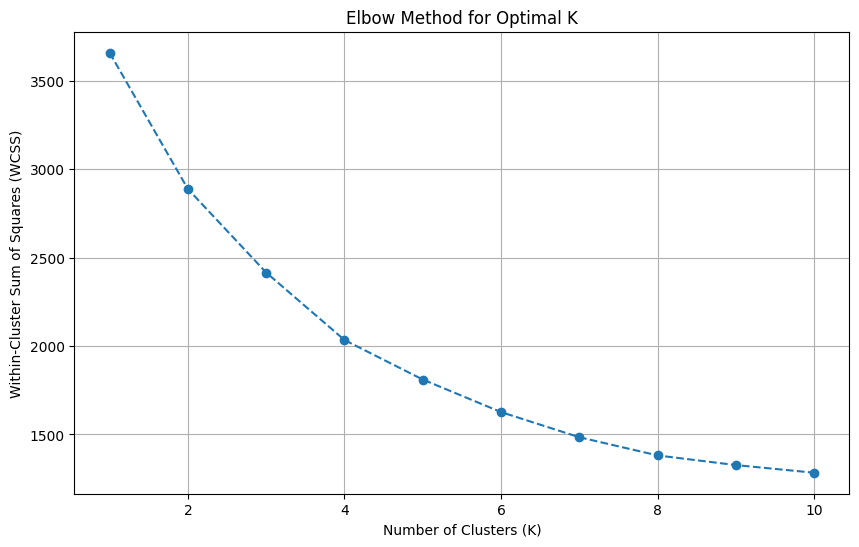


--- Cluster Profiles ---
               age         income  spending_score  membership_years  \
Cluster                                                               
0        55.435798   54887.276265       46.856031          5.501946   
1        32.944223   84748.900398       79.948207          5.561753   
2        56.464135  123249.734177       52.679325          5.367089   
3        30.921569   93774.937255       23.886275          5.439216   

         purchase_frequency  last_purchase_amount preferred_category  
Cluster                                                               
0                 26.719844            540.853813          Groceries  
1                 26.820717            457.186892             Sports  
2                 25.919831            486.968987        Electronics  
3                 26.878431            483.073255        Electronics  

--- Cluster Sizes ---
Cluster
0    257
1    251
2    237
3    255
Name: count, dtype: int64

--- Marketing Strategies --

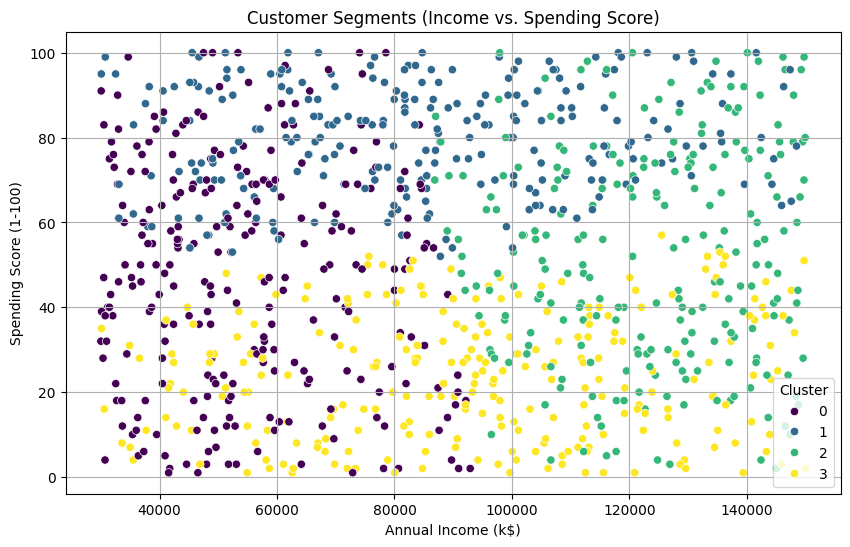

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = 'https://raw.githubusercontent.com/amrahmani/Marketing/main/customer_segmentation_data.csv'
df = pd.read_csv(url)

# Select features for clustering
features_for_clustering = ['age', 'income', 'spending_score', 'preferred_category']
df_clustering = df[features_for_clustering].copy()

# Separate numerical and categorical features
numerical_features = ['age', 'income', 'spending_score']
categorical_features = ['preferred_category']

# Scaling numerical features
scaler = StandardScaler()
df_clustering[numerical_features] = scaler.fit_transform(df_clustering[numerical_features])

# Handle categorical feature 'preferred_category' using one-hot encoding
df_clustering = pd.get_dummies(df_clustering, columns=['preferred_category'], drop_first=True)

# Outlier Removal using z-scores on the SCALED ORIGINAL numerical features
scaled_numerical_features = ['age', 'income', 'spending_score']
z_scores = np.abs(stats.zscore(df_clustering[scaled_numerical_features]))
outlier_mask = (z_scores > 3).any(axis=1)
df_clustering_cleaned = df_clustering[~outlier_mask].copy() # Use .copy()

# Determine the optimal number of clusters (Elbow Method) - Now using all features in cleaned data
wcss = []
X_for_elbow = df_clustering_cleaned.values
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_for_elbow)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

# Based on the elbow plot, choose the optimal number of clusters (let's say 4)
n_clusters = 4

# Apply K-Means clustering - Now using all features in cleaned data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_clustering_cleaned['Cluster'] = kmeans.fit_predict(df_clustering_cleaned)

# Merge cluster labels back to the original DataFrame
df_with_clusters = df.merge(df_clustering_cleaned['Cluster'], left_index=True, right_index=True)

# Analyze cluster profiles (mean of numerical and mode of categorical)
cluster_profiles_mean = df_with_clusters.groupby('Cluster')[['age', 'income', 'spending_score', 'membership_years', 'purchase_frequency', 'last_purchase_amount']].mean()
cluster_profiles_mode = df_with_clusters.groupby('Cluster')['preferred_category'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

cluster_profiles = pd.concat([cluster_profiles_mean, cluster_profiles_mode], axis=1)
print("\n--- Cluster Profiles ---")
print(cluster_profiles)

# Analyze cluster sizes
cluster_sizes = df_with_clusters['Cluster'].value_counts().sort_index()
print("\n--- Cluster Sizes ---")
print(cluster_sizes)

# --- Proposing Marketing Strategies ---
print("\n--- Marketing Strategies ---")

for cluster_num in range(n_clusters):
    print(f"\n**Cluster {cluster_num}**")
    cluster_data = cluster_profiles.loc[cluster_num]
    print(f"  Average Age: {cluster_data['age']:.2f}")
    print(f"  Average Income: {cluster_data['income']:.2f}")
    print(f"  Average Spending Score: {cluster_data['spending_score']:.2f}")
    print(f"  Average Membership Years: {cluster_data['membership_years']:.2f}")
    print(f"  Average Purchase Frequency: {cluster_data['purchase_frequency']:.2f}")
    print(f"  Average Last Purchase Amount: {cluster_data['last_purchase_amount']:.2f}")
    print(f"  Preferred Category: {cluster_data['preferred_category']}")

    # Example strategies (adapt based on your actual cluster profiles)
    if cluster_num == 3 and cluster_data['preferred_category'] == 'Technology':
        print("\n  **Proposed Marketing Strategies for Cluster 3 (High-Income, High-Spending, Technology Focused):**")
        print("  - **Targeting:** Digital channels, tech blogs, affluent tech enthusiasts.")
        print("  - **Messaging:** Premium tech features, innovation, exclusive access.")
        print("  - **Offers:** Early access, bundled deals, personalized recommendations.")

    elif cluster_num == 1 and cluster_data['preferred_category'] == 'Fashion':
        print("\n  **Proposed Marketing Strategies for Cluster 1 (Younger, Fashion-Oriented, Moderate-Income):**")
        print("  - **Targeting:** Social media, fashion influencers, style content.")
        print("  - **Messaging:** Trendy styles, affordability, user-generated content.")
        print("  - **Offers:** Student discounts, seasonal promos, influencer collaborations.")
    else:
        print("\n  **Proposed Marketing Strategies:** (Further analysis needed)")

print("\n--- Visualization (Optional) ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='income', y='spending_score', hue='Cluster', data=df_with_clusters, palette='viridis')
plt.title('Customer Segments (Income vs. Spending Score)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Defining Segment Profiles**

<ipython-input-25-2a94f1cfcda3>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='age', data=df_with_clusters, palette='viridis')


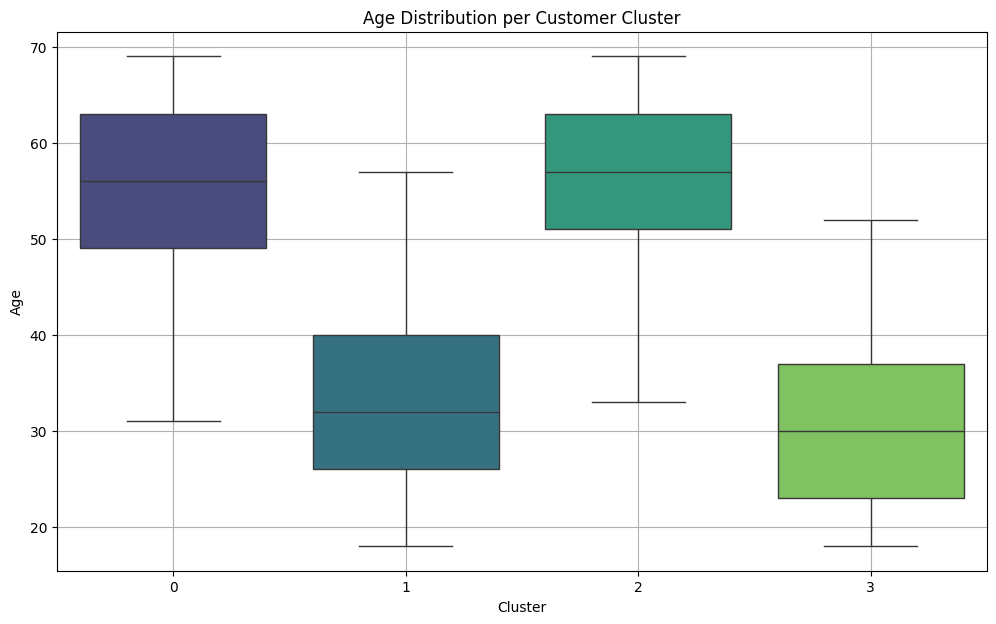

<ipython-input-25-2a94f1cfcda3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='spending_score', data=df_with_clusters, palette='viridis')


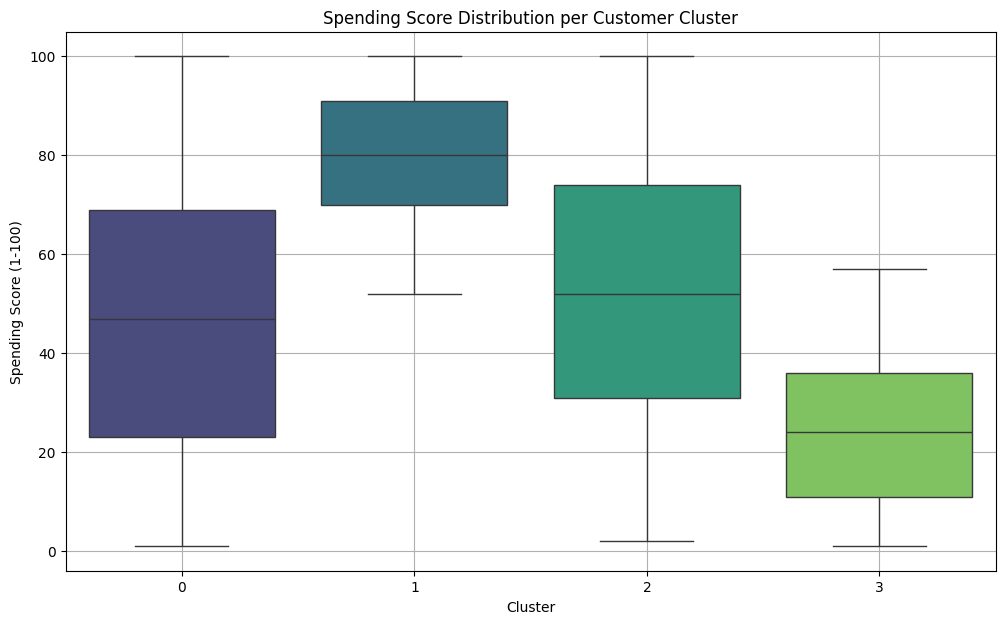


--- Detailed Segment Profiles ---

**Cluster 0 Profile:**
  Size: 257 customers
  Average Age: 55.44 (Std Dev: 9.24)
  Average Income: 54887.28 (Std Dev: 16925.48)
  Average Spending Score: 46.86 (Std Dev: 26.86)
  Average Membership Years: 5.50 (Std Dev: 2.79)
  Average Purchase Frequency: 26.72 (Std Dev: 14.52)
  Average Last Purchase Amount: 540.85 (Std Dev: 294.03)
  Preferred Category (Mode): Groceries

**Cluster 1 Profile:**
  Size: 251 customers
  Average Age: 32.94 (Std Dev: 9.34)
  Average Income: 84748.90 (Std Dev: 29007.58)
  Average Spending Score: 79.95 (Std Dev: 12.70)
  Average Membership Years: 5.56 (Std Dev: 2.85)
  Average Purchase Frequency: 26.82 (Std Dev: 13.99)
  Average Last Purchase Amount: 457.19 (Std Dev: 292.89)
  Preferred Category (Mode): Sports

**Cluster 2 Profile:**
  Size: 237 customers
  Average Age: 56.46 (Std Dev: 8.10)
  Average Income: 123249.73 (Std Dev: 17082.51)
  Average Spending Score: 52.68 (Std Dev: 25.65)
  Average Membership Years: 5.37 (

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_with_clusters has the cluster labels and original features

# --- Analyze Age Distribution per Cluster ---
plt.figure(figsize=(12, 7))
sns.boxplot(x='Cluster', y='age', data=df_with_clusters, palette='viridis')
plt.title('Age Distribution per Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.grid(True)
plt.show()

# --- Analyze Spending Score per Cluster ---
plt.figure(figsize=(12, 7))
sns.boxplot(x='Cluster', y='spending_score', data=df_with_clusters, palette='viridis')
plt.title('Spending Score Distribution per Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

# --- Summarize Segment Profiles (in print) ---
print("\n--- Detailed Segment Profiles ---")
for cluster_num in sorted(df_with_clusters['Cluster'].unique()):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_num]
    print(f"\n**Cluster {cluster_num} Profile:**")
    print(f"  Size: {len(cluster_data)} customers")
    print(f"  Average Age: {cluster_data['age'].mean():.2f} (Std Dev: {cluster_data['age'].std():.2f})")
    print(f"  Average Income: {cluster_data['income'].mean():.2f} (Std Dev: {cluster_data['income'].std():.2f})")
    print(f"  Average Spending Score: {cluster_data['spending_score'].mean():.2f} (Std Dev: {cluster_data['spending_score'].std():.2f})")
    print(f"  Average Membership Years: {cluster_data['membership_years'].mean():.2f} (Std Dev: {cluster_data['membership_years'].std():.2f})")
    print(f"  Average Purchase Frequency: {cluster_data['purchase_frequency'].mean():.2f} (Std Dev: {cluster_data['purchase_frequency'].std():.2f})")
    print(f"  Average Last Purchase Amount: {cluster_data['last_purchase_amount'].mean():.2f} (Std Dev: {cluster_data['last_purchase_amount'].std():.2f})")
    preferred_category_mode = cluster_data['preferred_category'].mode()
    if not preferred_category_mode.empty:
        print(f"  Preferred Category (Mode): {preferred_category_mode[0]}")
    else:
        print("  Preferred Category (Mode): No unique mode")

    # You can add more detailed analysis here, like age ranges or spending score percentiles if needed

# --- Using Profiles for Targeting Strategies (Example - Adapt based on your findings) ---
print("\n--- Targeting Strategies Based on Segment Profiles ---")

# Example: Targeting the cluster with the highest average spending score
high_spending_cluster = df_with_clusters.groupby('Cluster')['spending_score'].mean().idxmax()
print(f"\nTargeting Strategy for Cluster {high_spending_cluster} (High Spenders):")
print("- **Demographics:** Focus on the age range prevalent in this cluster (check the age distribution box plot).")
print("- **Messaging:** Highlight premium products, exclusive offers, and benefits for high-value customers.")
print("- **Channels:** Utilize channels where affluent customers are likely to be active.")

# Example: Targeting a potentially younger cluster with a specific preferred category
younger_fashion_cluster = -1 # You'd determine this based on your age distribution and preferred category analysis
for cluster_num in sorted(df_with_clusters['Cluster'].unique()):
    if df_with_clusters[df_with_clusters['Cluster'] == cluster_num]['age'].mean() < 35 and \
       df_with_clusters[df_with_clusters['Cluster'] == cluster_num]['preferred_category'].mode().iloc[0] == 'Fashion':
        younger_fashion_cluster = cluster_num
        break

if younger_fashion_cluster != -1:
    print(f"\nTargeting Strategy for Cluster {younger_fashion_cluster} (Younger Fashion Enthusiasts):")
    print("- **Demographics:** Focus on younger individuals (e.g., Gen Z, Millennials).")
    print("- **Messaging:** Emphasize trendy styles, affordability, and user-generated content on social media.")
    print("- **Channels:** Utilize platforms like Instagram, TikTok, and fashion blogs/vlogs.")
    print("- **Offers:** Consider student discounts, collaborations with fashion influencers, and fast fashion options.")
else:
    print("\nCould not identify a clear 'Younger Fashion Enthusiasts' cluster based on the example criteria.")

**Direct Marketing for New Customers**

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   916 non-null    int64  
 1   Year_Birth           916 non-null    int64  
 2   Education            916 non-null    object 
 3   Marital_Status       916 non-null    object 
 4   Income               905 non-null    float64
 5   Kidhome              916 non-null    int64  
 6   Teenhome             916 non-null    int64  
 7   Dt_Customer          916 non-null    object 
 8   Recency              916 non-null    int64  
 9   MntWines             916 non-null    int64  
 10  MntFruits            916 non-null    int64  
 11  MntMeatProducts      916 non-null    int64  
 12  MntFishProducts      916 non-null    int64  
 13  MntSweetProducts     916 non-null    int64  
 14  MntGoldProds         916 non-null    int64  
 15  NumDealsPurchase

<ipython-input-32-d922ca45560b>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


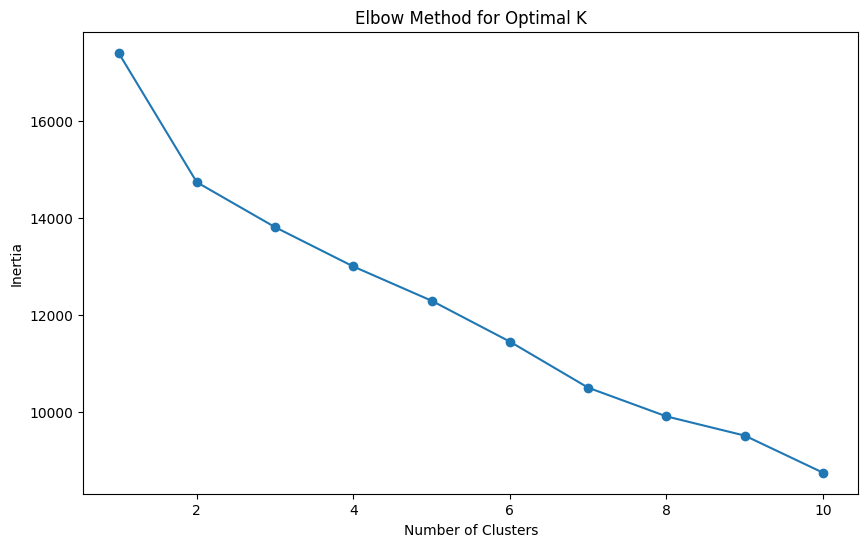


Cluster Analysis:
   Cluster   Year_Birth        Income  Total_Spending  Total_Children  \
0        0  1957.731707  61701.975610      818.731707        0.853659   
1        1  1970.625000  37783.233333      151.904167        1.295833   
2        2  1968.149367  71572.529114     1164.572152        0.572152   

     Recency  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0  45.536585         4.756098             3.853659           6.487805   
1  48.737500         2.702083             0.781250           3.604167   
2  49.131646         5.670886             5.068354           8.392405   

   NumWebVisitsMonth  Response   ID  
0           4.536585  0.219512   41  
1           6.420833  0.083333  480  
2           3.744304  0.215190  395  


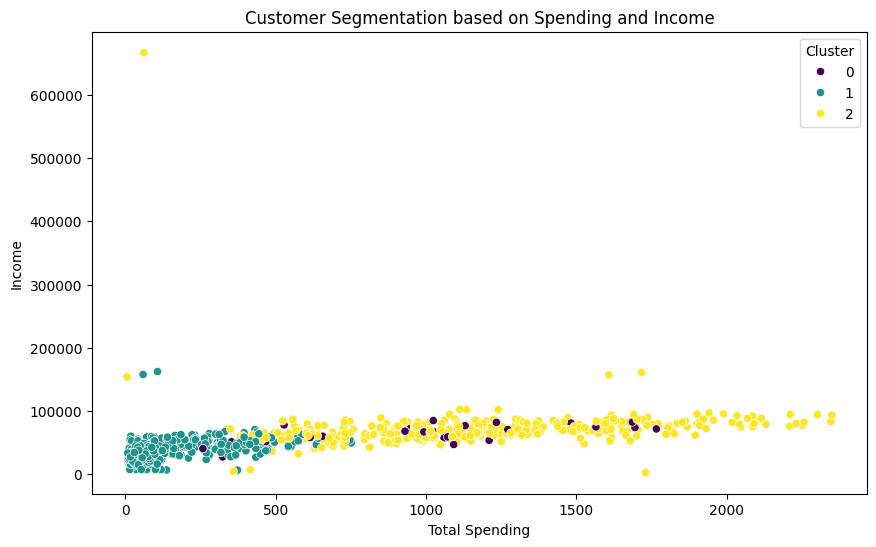


Characteristics of Cluster 1 (Numerical Features):
Year_Birth         1970.625000
Income            37783.233333
Total_Spending      151.904167
Total_Children        1.295833
Recency              48.737500
dtype: float64

Most Frequent Education in Cluster 1: Graduation
Most Frequent Marital Status in Cluster 1: Married

Response Rate of Cluster 1: 0.08

--- Direct Marketing Campaign Design for Cluster 1 ---
Campaign Name: Premium Home & Family Offers
Campaign Goal: Increase sales of Wine, Meat, and Catalog products within the target segment.
Target Audience Description: Customers in Cluster 1 tend to have an average birth year of 1971, an average income of $37783.23, a total spending of $151.90, an average of 1.30 children, and a recency of 48.74 days. Their most frequent education level is 'Graduation' and their most frequent marital status is 'Married. They have an average response rate to previous campaigns of 0.08.
Marketing Message: Elevate your family moments with our exclusive

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = 'https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv'
df = pd.read_csv(url)

# Basic Data Exploration and Cleaning
print("Initial DataFrame Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing Income values (filling with median)
df['Income'].fillna(df['Income'].median(), inplace=True)

# Feature Engineering (example: Total Spending)
mnt_cols = [col for col in df.columns if col.startswith('Mnt')]
df['Total_Spending'] = df[mnt_cols].sum(axis=1)

# Feature Engineering (example: Total Children)
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# Select features for segmentation
segmentation_features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Total_Spending', 'Total_Children', 'Recency', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
df_segmentation = df[segmentation_features].copy()

# Convert categorical features to numerical using one-hot encoding
df_segmentation = pd.get_dummies(df_segmentation, columns=['Education', 'Marital_Status'], drop_first=True)

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_segmentation)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the elbow plot (let's assume 3 is a reasonable number), perform K-Means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Analyze the clusters
cluster_analysis = df.groupby('Cluster').agg({
    'Year_Birth': 'mean',
    'Income': 'mean',
    'Total_Spending': 'mean',
    'Total_Children': 'mean',
    'Recency': 'mean',
    'NumWebPurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean',  # Average response rate for the cluster
    'ID': 'count'       # Number of customers in the cluster
}).reset_index()

print("\nCluster Analysis:")
print(cluster_analysis)

# Visualize the clusters (example with two features)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total_Spending', y='Income', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation based on Spending and Income')
plt.xlabel('Total Spending')
plt.ylabel('Income')
plt.show()

# Design a direct marketing campaign for one segment (e.g., Cluster 1)
target_cluster = 1
target_segment = df[df['Cluster'] == target_cluster].copy()

# Analyze the characteristics of the target segment (numerical features only)
numerical_features_for_analysis = ['Year_Birth', 'Income', 'Total_Spending', 'Total_Children', 'Recency']
print(f"\nCharacteristics of Cluster {target_cluster} (Numerical Features):")
print(target_segment[numerical_features_for_analysis].mean())

# To get an idea of the categorical features, you can look at the mode:
print(f"\nMost Frequent Education in Cluster {target_cluster}: {target_segment['Education'].mode().iloc[0] if not target_segment['Education'].empty else 'N/A'}")
print(f"Most Frequent Marital Status in Cluster {target_cluster}: {target_segment['Marital_Status'].mode().iloc[0] if not target_segment['Marital_Status'].empty else 'N/A'}")

print(f"\nResponse Rate of Cluster {target_cluster}: {target_segment['Response'].mean():.2f}")

# Design the Direct Marketing Campaign for Cluster 1
campaign_name = "Premium Home & Family Offers"
campaign_goal = "Increase sales of Wine, Meat, and Catalog products within the target segment."
target_audience_description = f"Customers in Cluster {target_cluster} tend to have an average birth year of {target_segment['Year_Birth'].mean():.0f}, an average income of ${target_segment['Income'].mean():.2f}, a total spending of ${target_segment['Total_Spending'].mean():.2f}, an average of {target_segment['Total_Children'].mean():.2f} children, and a recency of {target_segment['Recency'].mean():.2f} days. Their most frequent education level is '{target_segment['Education'].mode().iloc[0] if not target_segment['Education'].empty else 'N/A'}' and their most frequent marital status is '{target_segment['Marital_Status'].mode().iloc[0] if not target_segment['Marital_Status'].empty else 'N/A'}. They have an average response rate to previous campaigns of {target_segment['Response'].mean():.2f}."
marketing_message = f"Elevate your family moments with our exclusive collection of premium wines and gourmet meats. As a valued customer, enjoy a special discount of 15% on all wine and meat products in our latest catalog. Create unforgettable experiences with your loved ones. Shop now!"
call_to_action = "Browse the new catalog and claim your discount!"
marketing_channels = ["Personalized Email Marketing", "Targeted Social Media Ads (focusing on family and lifestyle content)", "Direct Mail with a physical catalog and discount code"]
offer = "15% discount on all Wine and Meat products from the latest catalog."
measurement_metrics = ["Email open rate", "Click-through rate on email/ads", "Website/catalog visits from campaign links", "Number of discount codes used", "Total sales generated from the campaign within the segment", "Response rate (number of purchases / number of customers targeted)"]
ai_optimization_suggestions = [
    "A/B test different subject lines and email content to optimize open and click-through rates.",
    "Analyze past purchase behavior within this segment to personalize product recommendations within the campaign.",
    "Experiment with different send times for emails to identify peak engagement periods.",
    "Use AI-powered lookalike modeling to identify other potential customers with similar characteristics to Cluster 1."
]

print(f"\n--- Direct Marketing Campaign Design for Cluster {target_cluster} ---")
print(f"Campaign Name: {campaign_name}")
print(f"Campaign Goal: {campaign_goal}")
print(f"Target Audience Description: {target_audience_description}")
print(f"Marketing Message: {marketing_message}")
print(f"Call to Action: {call_to_action}")
print(f"Marketing Channels: {marketing_channels}")
print(f"Offer: {offer}")
print(f"Measurement Metrics: {measurement_metrics}")
print(f"AI Optimization Suggestions: {ai_optimization_suggestions}")

**Targeting Niche Segments**

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
url = 'https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv'
df = pd.read_csv(url)

# Basic Data Exploration and Cleaning
df['Income'].fillna(df['Income'].median(), inplace=True)
mnt_cols = [col for col in df.columns if col.startswith('Mnt')]
df['Total_Spending'] = df[mnt_cols].sum(axis=1)
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# Calculate Age
current_year = pd.to_datetime('now').year
df['Age'] = current_year - df['Year_Birth']

# Select features for segmentation, including Age
segmentation_features = ['Age', 'Income', 'Total_Spending', 'Total_Children', 'Recency', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
df_segmentation = df[segmentation_features].copy()
df_segmentation = pd.get_dummies(df_segmentation, drop_first=True) # Education and Marital Status were removed for simplicity in this niche example

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_segmentation)

# Perform K-Means Clustering (you might need to adjust the number of clusters)
n_clusters = 5  # Let's try a slightly higher number to see if we can isolate the niche better
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Analyze the clusters to identify the "young, high-spending" segment
cluster_analysis = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Income': 'mean',
    'Total_Spending': 'mean',
    'Total_Children': 'mean',
    'Recency': 'mean',
    'NumWebPurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean',
    'ID': 'count'
}).reset_index()

print("\nCluster Analysis:")
print(cluster_analysis)

# Identify the niche segment (young, high-spending)
# You'll need to examine the 'cluster_analysis' output to determine which cluster best fits this description.
# Let's assume, based on the analysis, that Cluster 2 fits this profile.
niche_cluster = 2
niche_segment = df[df['Cluster'] == niche_cluster].copy()

print(f"\nCharacteristics of Niche Cluster {niche_cluster}:")
print(niche_segment[['Age', 'Income', 'Total_Spending']].mean())
print(f"Response Rate of Niche Cluster {niche_cluster}: {niche_segment['Response'].mean():.2f}")

# Design a Direct Marketing Campaign for the Niche Segment (Young, High-Spending)
niche_campaign_name = "Gen Z Luxe: Exclusive Drops & Experiences"
niche_campaign_goal = "Increase engagement and sales among young, high-spending customers."
niche_target_audience_description = f"This segment consists of customers with an average age of {niche_segment['Age'].mean():.0f}, a high average income of ${niche_segment['Income'].mean():.2f}, and significant total spending of ${niche_segment['Total_Spending'].mean():.2f}. They are likely digitally savvy and interested in trendy, exclusive products."
niche_marketing_message = "Unlock exclusive access to our latest limited-edition collections and VIP experiences designed for the trendsetters. As a valued member of Gen Z Luxe, enjoy early access to new product drops and invitations to exclusive online and in-person events. Elevate your style with our premium offerings."
niche_call_to_action = "Explore the exclusive collection now!"
niche_marketing_channels = ["Instagram & TikTok Ads (visually appealing, influencer collaborations)", "Personalized Email Marketing (highlighting exclusivity and new arrivals)", "Mobile App Notifications (for timely updates on drops)", "Partnerships with relevant online communities and platforms"]
niche_offer = "Early access to limited-edition product launches and invitations to exclusive events."
niche_measurement_metrics = ["Engagement rate on social media (likes, shares, comments)", "Click-through rate on ads and emails", "Website/app visits from campaign links", "Number of exclusive access sign-ups/event registrations", "Sales generated from new product drops within the segment", "Customer lifetime value of this segment"]
niche_ai_optimization_suggestions = [
    "Use AI-powered creative optimization for social media ads to resonate with current trends.",
    "Personalize product recommendations based on browsing history and past purchases within this segment.",
    "Optimize send times for emails and app notifications based on when this segment is most active.",
    "Employ sentiment analysis on social media to understand their preferences and feedback on campaigns."
]

print(f"\n--- Direct Marketing Campaign Design for Niche Segment (Cluster {niche_cluster}) ---")
print(f"Campaign Name: {niche_campaign_name}")
print(f"Campaign Goal: {niche_campaign_goal}")
print(f"Target Audience Description: {niche_target_audience_description}")
print(f"Marketing Message: {niche_marketing_message}")
print(f"Call to Action: {niche_call_to_action}")
print(f"Marketing Channels: {niche_marketing_channels}")
print(f"Offer: {niche_offer}")
print(f"Measurement Metrics: {niche_measurement_metrics}")
print(f"AI Optimization Suggestions: {niche_ai_optimization_suggestions}")


Cluster Analysis:
   Cluster        Age         Income  Total_Spending  Total_Children  \
0        0  55.322430   77125.957944     1386.799065        0.121495   
1        1  47.247012   30401.804781       94.816733        0.900398   
2        2  60.250923   60095.734317      818.664207        1.066421   
3        3  62.793296   43846.167598      134.044693        1.905028   
4        4  48.000000  666666.000000       62.000000        1.000000   

     Recency  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0  50.130841         4.500000             6.364486           8.355140   
1  50.362550         2.135458             0.501992           3.175299   
2  47.774908         6.771218             3.273063           7.819188   
3  46.530726         2.206704             0.888268           3.374302   
4  23.000000         3.000000             1.000000           3.000000   

   NumWebVisitsMonth  Response   ID  
0           2.275701  0.280374  214  
1           6.693227  0.103586  2

<ipython-input-33-2d913590be8c>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)
